# SNR Experiment Runner

This notebook orchestrates the eight-case SNR experiment for PRISMA and EnMAP scenes using the consolidated CLI entry point `scripts.snr_experiment`. Each run generates striping diagnostics, PCA visualisations, and per-case CSV/PNG outputs inside `outputs/<sensor>/<scene_id>/`.

## Prerequisites

- Install the Python dependencies required by the SNR workflow (`numpy`, `scipy`, `scikit-learn`, `matplotlib`, `scikit-image` if you want Sobel-based masks).
- Ensure PRISMA `.he5`/`.zip` files or EnMAP VNIR/SWIR GeoTIFFs and `METADATA.XML` are accessible from this repository.
- Adjust the scene configuration below to point to your local datasets (ROIs and band windows are optional).

In [45]:
import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime
from typing import Iterable, Optional

from IPython.display import Markdown, display

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")
os.environ["PYTHONPATH"] = str(REPO_ROOT)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
PYTHON = sys.executable

display(Markdown(
    f"**Notebook root**: `{REPO_ROOT}`  \
     **Python**: `{PYTHON}`  \
     **PYTHONPATH**: `{os.environ['PYTHONPATH']}`"
))

**Notebook root**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`       **Python**: `/home/esivla/miniconda3/envs/hygasMF/bin/python`       **PYTHONPATH**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`

In [46]:
def run_snr_experiment(
    sensor: str,
    inputs: Iterable[str],
    roi: Optional[str] = None,
    bands: Optional[str] = None,
    cases: Optional[str] = None,
    disable_notch: bool = False,
    extra_args: Optional[Iterable[str]] = None,
    outdir: Optional[str] = None,
):
    """Invoke the CLI for a single scene and return the completed process."""

    cmd = [
        PYTHON,
        "-m",
        "scripts.snr_experiment",
        "--sensor",
        sensor,
        "--input",
    ]
    cmd.extend(str(path) for path in inputs)
    if roi:
        cmd.extend(["--roi", roi])
    if bands:
        cmd.extend(["--bands", bands])
    if cases:
        cmd.extend(["--cases", cases])
    if disable_notch:
        cmd.append("--disable-notch")
    if outdir:
        cmd.extend(["--outdir", outdir])
    if extra_args:
        cmd.extend(str(arg) for arg in extra_args)

    display(Markdown(f"**Running**: `{' '.join(cmd)}`"))
    start = datetime.now()
    result = subprocess.run(cmd, capture_output=True, text=True, env=os.environ.copy())
    duration = datetime.now() - start
    status = "success" if result.returncode == 0 else f"failed (code {result.returncode})"

    display(Markdown(f"- Status: **{status}** in {duration.total_seconds():.1f}s"))
    if result.stdout:
        display(Markdown(f"<details><summary>stdout</summary><pre>{result.stdout}</pre></details>"))
    if result.stderr:
        display(Markdown(f"<details><summary>stderr</summary><pre>{result.stderr}</pre></details>"))

    return result


## Configure Scenes

Populate the list below with the scenes you want to process. Each configuration corresponds to one CLI call. Paths can point to raw `.zip` archives (PRISMA) or directories containing EnMAP VNIR/SWIR products. Leave the list empty to skip execution.

In [47]:
SCENE_CONFIGS = [
    #Example:
    {
        "sensor": "prisma",
        "inputs": [
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip",
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip",
        ],
        #"roi": "100:400,50:350",  # optional
        "bands": "1000:2500",      # optional spectral window in nm
        "cases": "A,B,C,D,E,F,G,H",
        "disable_notch": False,
        "extra_args": ["--mask-frac", "0.12", "--diff-axis", "columns", "--k-pca", "4"],
    },
]
SCENE_CONFIGS

[{'sensor': 'prisma',
  'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip',
   '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'],
  'bands': '1000:2500',
  'cases': 'A,B,C,D,E,F,G,H',
  'disable_notch': False,
  'extra_args': ['--mask-frac',
   '0.12',
   '--diff-axis',
   'columns',
   '--k-pca',
   '4']}]

## Run Experiments

In [48]:
results = []
for cfg in SCENE_CONFIGS:
    result = run_snr_experiment(**cfg)
    results.append((cfg, result))
    if result.returncode != 0:
        break

results

**Running**: `/home/esivla/miniconda3/envs/hygasMF/bin/python -m scripts.snr_experiment --sensor prisma --input /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip --bands 1000:2500 --cases A,B,C,D,E,F,G,H --mask-frac 0.12 --diff-axis columns --k-pca 4`

- Status: **success** in 77.4s

<details><summary>stdout</summary><pre>SNR experiment completed. Outputs stored in outputs/prisma/20200401085313
</pre></details>

<details><summary>stderr</summary><pre>/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/scripts/diagnostics/striping.py:185: RuntimeWarning: Mean of empty slice
  mean_original = np.nanmean(np.where(row_mask, img2d[r], np.nan))
/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/scripts/diagnostics/plots.py:21: RuntimeWarning: Mean of empty slice
  col_mean = np.nanmean(values, axis=0)
/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
</pre></details>

[({'sensor': 'prisma',
   'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip',
    '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'],
   'bands': '1000:2500',
   'cases': 'A,B,C,D,E,F,G,H',
   'disable_notch': False,
   'extra_args': ['--mask-frac',
    '0.12',
    '--diff-axis',
    'columns',
    '--k-pca',
    '4']},
  CompletedProcess(args=['/home/esivla/miniconda3/envs/hygasMF/bin/python', '-m', 'scripts.snr_experiment', '--sensor', 'prisma', '--input', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_ST

## Inspect Outputs

The cell below searches the output directory for generated CSVs and PNGs so that you can quickly inspect the latest results.

Found 8 CSV files, 1 overview plots, and 1 striping diagnostics.

### prisma/20200401085313 / snr_cases_overview.png

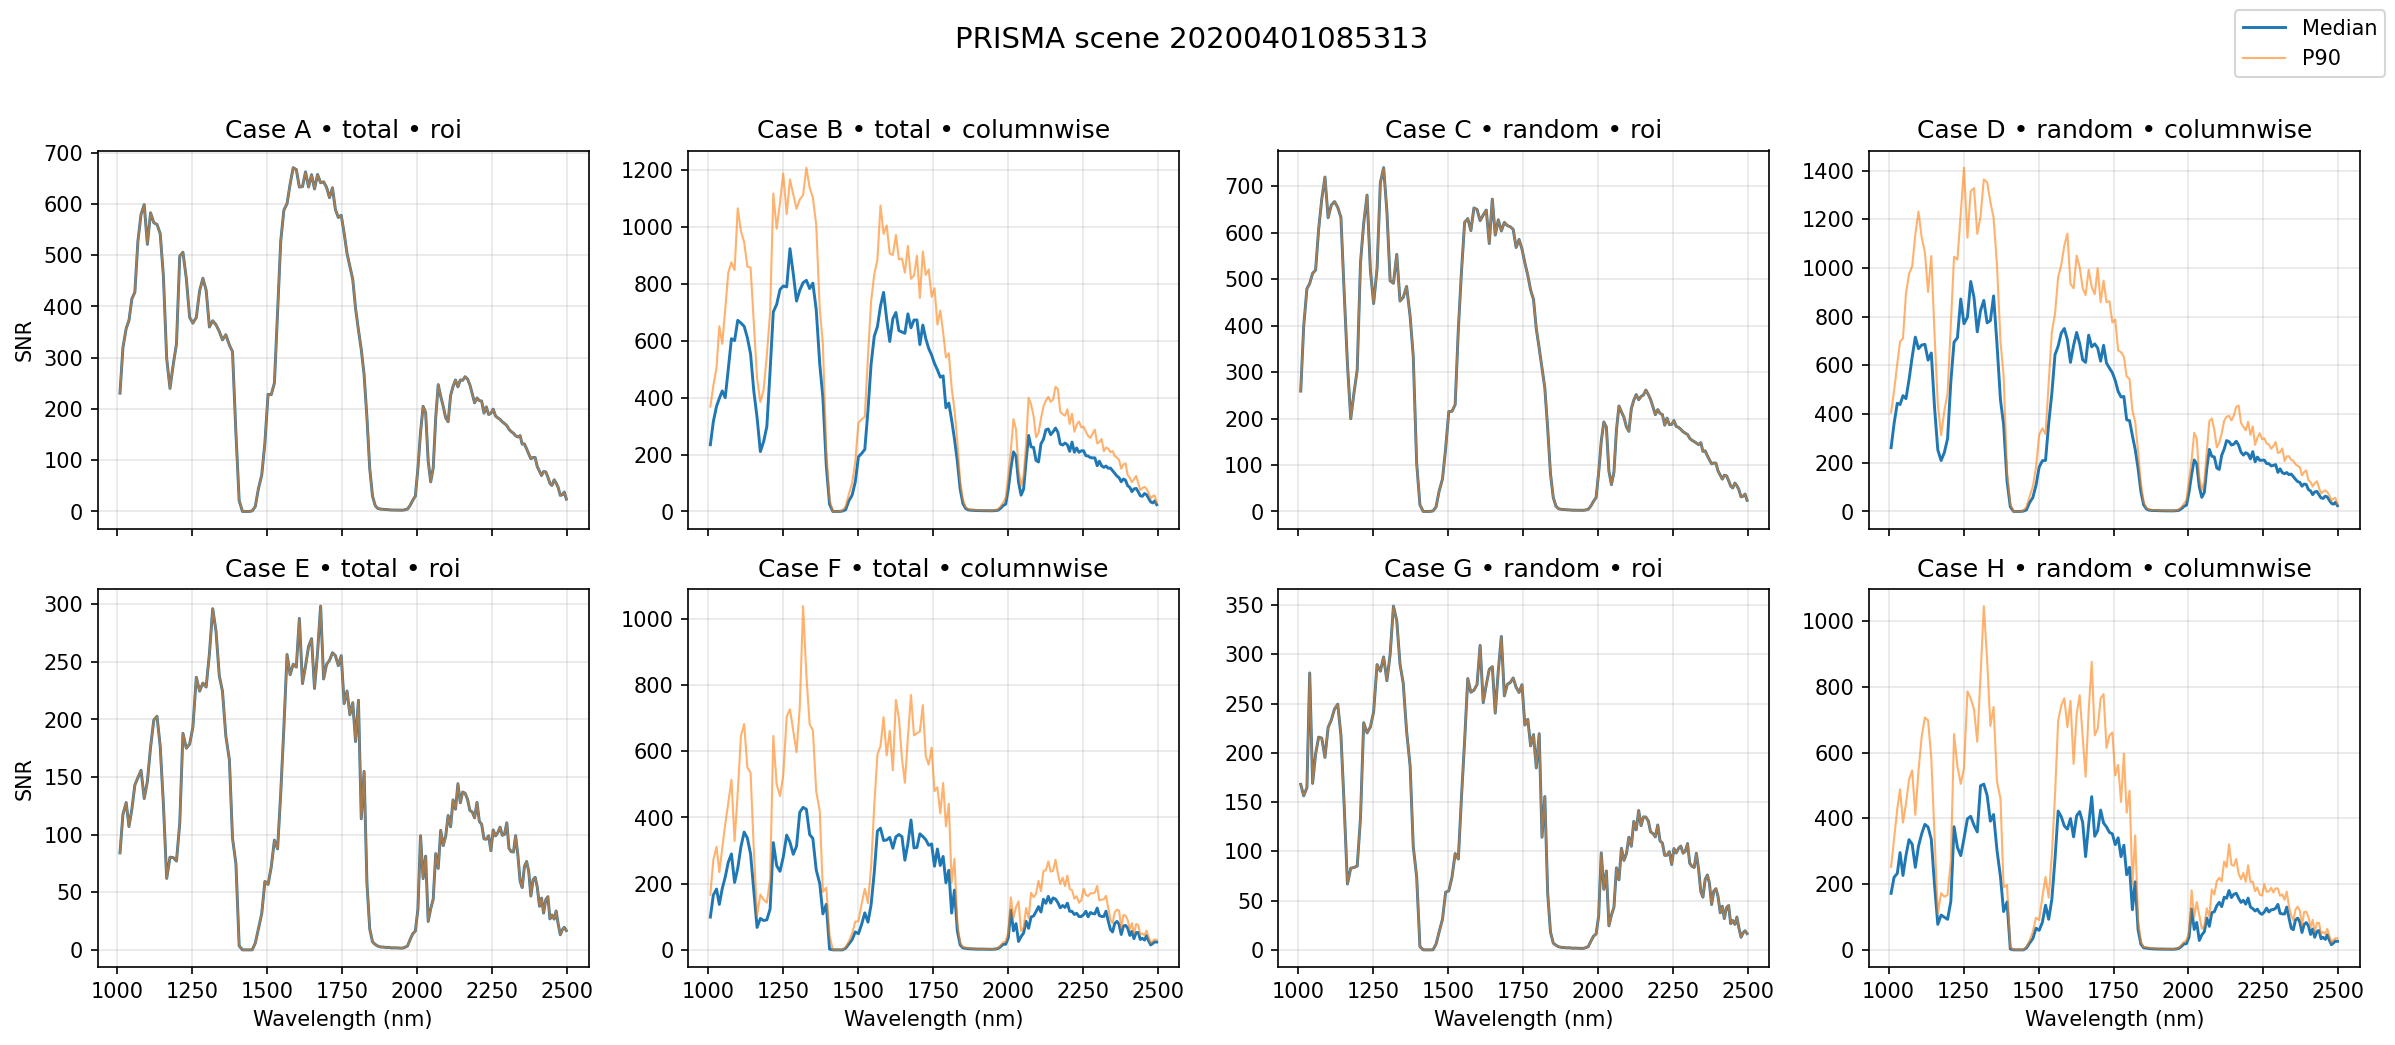

In [49]:
from glob import glob
from IPython.display import Image

output_root = Path("outputs")
if output_root.exists():
    csv_paths = sorted(output_root.glob("**/snr_cases_*.csv"))
    overview_pngs = sorted(output_root.glob("**/snr_cases_overview.png"))
    striping_pngs = sorted(output_root.glob("**/striping_diagnostics.png"))

    display(Markdown(f"Found {len(csv_paths)} CSV files, {len(overview_pngs)} overview plots, and {len(striping_pngs)} striping diagnostics."))

    for png in overview_pngs:
        display(Markdown(f"### {png.parent.relative_to(output_root)} / {png.name}"))
        display(Image(filename=str(png)))
else:
    display(Markdown("`outputs/` directory not found yet. Run at least one experiment."))